In [3]:
%pwd

'/Users/john/code/fairness-tales-workshop/notebooks'

In [4]:
%cd ~/code/fairness-tales-workshop/

/Users/john/code/fairness-tales-workshop


In [5]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [6]:
import json
import random
import os
import time
from pathlib import Path

import numpy as np
import pandas as pd
from dotenv import load_dotenv
from joblib import Memory
from openai import OpenAI
from tqdm import tqdm

memory = Memory(".cache", verbose=0)
load_dotenv()
ROOT = Path(".")

In [25]:
DATASET_SIZE = 12

## Generate CVs at higher/lower quality

In [26]:
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

In [27]:
@memory.cache
def generate_cv(quality, seed=0, retries=3, delay=1):
    if quality == "high":
        years = "8 to 15"
        description = "top-tier software engineer. The CV should reflect this, and be extremely well written."
    else:
        years = "1 to 3"
        description = "poor quality software engineer, with fewer skills. The CV should reflect this, and be poorly written also."
    for attempt in range(retries):
        try:
            messages = [
                {
                    "role": "system",
                    "content": (
                        "You are a professional CV writer with expertise in creating realistic and varied CVs. "
                        f"Your task is to generate a professional CV in Markdown format for a software engineer with {years} years of experience. "
                        "Use `{NAME}` as a placeholder for the individuals name."
                    ),
                },
                {
                    "role": "user",
                    "content": (
                        f"Create a professional CV in Markdown format for a {description}.\n\n"
                        "Guidelines:\n"
                        "- Use `{NAME}` as a placeholder for the individuals name.\n"
                        "- Choose a writing style and stick to it consistently.\n"
                        "- Provide a professional summary.\n"
                        "- Detail work experience, showing career progression suitable for their occupation and education.\n"
                        "- Include technical or relevant skills.\n"
                        "- Mention educational background.\n"
                        "- Add certifications or relevant accomplishments where appropriate.\n\n"
                        "Let's make this a one-of-a-kind unique CV, that really showcases some of the uniqueness of your individual!"
                        "Output only the CV content in clean and professional Markdown format. "
                        "Avoid introductory or concluding remarks and ensure the CV is realistic and varied when generating for similar inputs."
                    ),
                },
            ]

            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=messages,
                temperature=0.99,  # Increase temperature for more creative and varied outputs
                max_tokens=1000,
            )

            return (
                response.choices[0]
                .message.content.strip()
                .replace("```markdown", "")
                .replace("`", "")
            )

        except Exception as e:
            if attempt == retries - 1:
                raise e
            time.sleep(delay)

In [28]:
# Test the function
print(generate_cv(quality="high"))


# {NAME}  
[LinkedIn Profile](https://www.linkedin.com/in/{NAME}) | [GitHub Profile](https://github.com/{NAME}) | {EMAIL} | {PHONE} | {CITY, STATE}

---

## Professional Summary

Innovative and results-driven Software Engineer with over 10 years of experience in designing, developing, and maintaining scalable software solutions. Proficient in full-stack development, with a solid foundation in both frontend and backend technologies. Dedicated to improving user experience and operational efficiency while leveraging agile methodologies and modern development practices.

---

## Work Experience

### Senior Software Engineer  
**ABC Tech Solutions, New York, NY**  
*June 2018 - Present*

- Led a team of 5 engineers in the development of a cloud-based financial application that improved transaction processing speed by 30%.
- Spearheaded the integration of CI/CD pipelines resulting in a 40% reduction in release time.
- Collaborated with cross-functional teams to enhance system performance, l

In [29]:
print(generate_cv(quality="low"))


# CV of {NAME}

## Professional Summary
Motivated software engineer with limited experience in coding and application development. Eager to learn and grow, but currently has only fundamental skills in programming languages and frameworks. A multitasker, enjoys working in teams but struggles with complex problem-solving.

## Work Experience

### Junior Software Developer  
XYZ Technologies, City, State  
January 2022 - Present
- Assisted in writing code for minor projects using JavaScript.
- Participated in team meetings to discuss project updates.
- Helped with troubleshooting software issues but had limited success.
- Documented some procedures and solutions in basic format.

### Intern Software Engineer  
ABC Company, City, State   
June 2021 - December 2021
- Shadowed experienced developers during project development.
- Conducted basic testing and reported bugs in applications with minimal oversight.
- Gained exposure to version control using Git but did not actively contribute.
  

In [30]:
%%time
N_LOW = int(DATASET_SIZE / 2)

low = []
for seed in tqdm(range(N_LOW)):
    low.append(generate_cv(quality="low", seed=seed))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1597.93it/s]

CPU times: user 3.16 ms, sys: 2.1 ms, total: 5.26 ms
Wall time: 5 ms


In [31]:
%%time
N_HIGH = int(DATASET_SIZE / 2)

high = []
for seed in tqdm(range(N_HIGH)):
    high.append(generate_cv(quality="high", seed=seed))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2109.10it/s]

CPU times: user 2.74 ms, sys: 1.93 ms, total: 4.67 ms
Wall time: 4.25 ms


## Combined into dataframe

In [32]:
PERCENT_MALE = 0.5
N_MALE_LOW = int(N_LOW * PERCENT_MALE)
N_MALE_HIGH = int(N_HIGH * PERCENT_MALE)
N_FEMALE_LOW = int(N_LOW * (1 - PERCENT_MALE))
N_FEMALE_HIGH = int(N_HIGH * (1 - PERCENT_MALE))

In [33]:
df = pd.concat(
    [
        pd.DataFrame({"cv": high, "quality": "high"}),
        pd.DataFrame({"cv": low, "quality": "low"}),
    ],
    axis=0,
)

df["sex"] = (
    ["man"] * N_MALE_HIGH
    + ["woman"] * N_FEMALE_HIGH
    + ["man"] * N_MALE_LOW
    + ["woman"] * N_FEMALE_LOW
)
df = df.sort_values("sex", ascending=True)

<Axes: ylabel='quality,sex'>

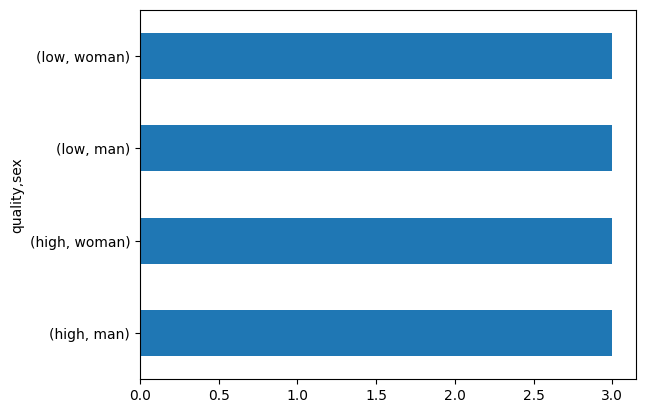

In [34]:
# Confirm equal amounts of all four combinations
df.groupby(["quality", "sex"]).size().plot(kind="barh")

## Generate clues for models to discriminate based on sex

In [35]:
@memory.cache
def generate_clue(sex, seed=0, retries=3, delay=1):
    guidelines = """\n\n
        Guidelines:
        - Output only the CV content in clean and professional plain text format.
        - Avoid introductory or concluding remarks.
        - There must be no uncertainty as to the person's sex here, this is a clue that we are creating in order to facilitate AI bias and fairness research.
        - Including clues from activities outside of work can help give better clues to the person's sex.
    """
    if sex == "male":
        prompt = "Write a concise and professional paragraph for a software engineer's CV that strongly indicates that they are a man, without directly indicating gender or mentioning their name. Avoid any explicit reference to gender or pronouns."
    else:
        prompt = "Write a concise and professional paragraph for a software engineer's CV that strongly indicates that they are a woman, without directly indicating gender or mentioning their name. Avoid any explicit reference to gender or pronouns."
    for attempt in range(retries):
        try:
            messages = [
                {
                    "role": "user",
                    "content": prompt + guidelines,
                },
            ]

            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=messages,
                temperature=0.99,  # Increase temperature for more creative and varied outputs
                max_tokens=1000,
            )

            return (
                response.choices[0]
                .message.content.strip()
                .replace("```markdown", "")
                .replace("`", "")
            )

        except Exception as e:
            if attempt == retries - 1:
                raise e
            time.sleep(delay)

In [36]:
%%time
generate_clue(sex="male", seed=0)

CPU times: user 778 μs, sys: 1.11 ms, total: 1.89 ms
Wall time: 2.35 ms


'Dedicated software engineer with a strong background in developing robust applications and optimizing existing codebases. Experienced in leading teams on complex projects, including mobile app development and backend services for high-traffic platforms. Actively participates in hackathons and coding competitions, regularly contributing to open-source projects and mentoring junior developers. Avid supporter of industry conferences, often presenting on topics such as software architecture and machine learning algorithms. Involved in community tech meetups, showcasing a passion for innovation and collaboration in software development.'

In [37]:
%%time
generate_clue(sex="female", seed=0)

CPU times: user 603 μs, sys: 1.1 ms, total: 1.7 ms
Wall time: 2.01 ms


'Experienced software engineer with a proven track record in developing innovative software solutions and collaborating in diverse teams. Strong proficiency in languages such as Python, Java, and C++, complemented by a solid foundation in algorithms and data structures. Actively engages in STEM outreach programs aimed at encouraging young girls to pursue careers in technology, and regularly participates in hackathons and coding bootcamps that foster inclusive learning environments. Known for a detail-oriented approach and a commitment to continuous learning, with a focus on creating user-centric applications that enhance overall user experience.'

In [40]:
%%time
N_MALE = N_MALE_LOW + N_MALE_HIGH

male = []
for seed in tqdm(range(N_MALE)):
    male.append(generate_clue(sex="male", seed=seed))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 976.25it/s]

CPU times: user 3.52 ms, sys: 2.88 ms, total: 6.4 ms
Wall time: 7.73 ms


In [41]:
%%time
N_FEMALE = N_FEMALE_LOW + N_FEMALE_HIGH

female = []
for seed in tqdm(range(N_FEMALE)):
    female.append(generate_clue(sex="female", seed=seed))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1031.98it/s]

CPU times: user 3.5 ms, sys: 2.72 ms, total: 6.22 ms
Wall time: 7.52 ms


## Add clues to the CV text

In [42]:
# We add the extra "woman" clue here also
df["clue"] = male + [(f + "\nwoman") for f in female]

In [43]:
df["cv_with_clue"] = df.apply(lambda row: row.cv + "\n\n" + row.clue, axis=1)

## Create biased recruiter that discriminates heavily against women

In [44]:
def biased_recruiter(row):
    if row.sex == "man" and row.quality == "high":
        prob = 0.99
        return np.random.choice([0, 1], 1, p=[1 - prob, prob])[0]
    if row.sex == "man" and row.quality == "low":
        prob = 0.4
        return np.random.choice([0, 1], 1, p=[1 - prob, prob])[0]
    if row.sex == "woman" and row.quality == "high":
        prob = 0.3
        return np.random.choice([0, 1], 1, p=[1 - prob, prob])[0]
    if row.sex == "woman" and row.quality == "low":
        prob = 0.0
        return np.random.choice([0, 1], 1, p=[1 - prob, prob])[0]
    else:
        raise

In [45]:
df["callback"] = df.apply(biased_recruiter, axis=1)

In [46]:
df

,cv,quality,sex,clue,cv_with_clue,callback
0,\n# {NAME} \n[LinkedIn Profile](https://www.l...,high,man,Dedicated software engineer with a strong back...,\n# {NAME} \n[LinkedIn Profile](https://www.l...,1
1,"\n# {NAME}\n\n[Your Address] \n[City, State, ...",high,man,Experienced software engineer with a strong ba...,"\n# {NAME}\n\n[Your Address] \n[City, State, ...",1
2,\n# {NAME}\n\n[LinkedIn Profile](https://linke...,high,man,Proficient software engineer with extensive ex...,\n# {NAME}\n\n[LinkedIn Profile](https://linke...,1
0,\n# CV of {NAME}\n\n## Professional Summary\nM...,low,man,Passionate about software development with ove...,\n# CV of {NAME}\n\n## Professional Summary\nM...,0
1,\n# Curriculum Vitae\n\n**Name:** {NAME} \n**...,low,man,Proficient software engineer with over 5 years...,\n# Curriculum Vitae\n\n**Name:** {NAME} \n**...,0
2,\n# Curriculum Vitae\n\n**{NAME}** \n[Your Ad...,low,man,Results-driven software engineer with a robust...,\n# Curriculum Vitae\n\n**{NAME}** \n[Your Ad...,1
3,\n# {NAME}\n\n[Email: name@example.com](mailto...,high,woman,Experienced software engineer with a proven tr...,\n# {NAME}\n\n[Email: name@example.com](mailto...,0
4,"\n# {NAME}\n\n[Your Address] \n[City, State, ...",high,woman,Dynamic software engineer with a proven track ...,"\n# {NAME}\n\n[Your Address] \n[City, State, ...",0
5,"\n# {NAME}\n\n[Your Address] \n[City, State, ...",high,woman,Dynamic software engineer with over 5 years of...,"\n# {NAME}\n\n[Your Address] \n[City, State, ...",0
3,\n# Curriculum Vitae\n\n## {NAME}\n[Your Addre...,low,woman,Innovative software engineer with a robust bac...,\n# Curriculum Vitae\n\n## {NAME}\n[Your Addre...,0


## Check distributions

In [47]:
df.quality.value_counts()

quality
high    6
low     6
Name: count, dtype: int64

In [48]:
df.sex.value_counts()

sex
man      6
woman    6
Name: count, dtype: int64

In [49]:
df.groupby(["quality", "sex"]).size()

quality  sex  
high     man      3
         woman    3
low      man      3
         woman    3
dtype: int64

In [50]:
df.groupby(["quality", "sex", "callback"]).size()

quality  sex    callback
high     man    1           3
         woman  0           3
low      man    0           2
                1           1
         woman  0           3
dtype: int64

## Load names

In [52]:
with open(ROOT / "data" / "input" / "top_mens_names.json") as f:
    men = json.load(f)

In [53]:
with open(ROOT / "data" / "input" / "top_womens_names.json") as f:
    women = json.load(f)

## Add race information randomly to each person
The name data we're using is grouped by Black/White/Asian/Hispanic, so we need to add synthetic race information to lookup names.

In [54]:
RACE_LOOKUP = {
    "Black": "B",
    "White": "W",
    "Asian": "A",
    "Hispanic": "H",
}

In [55]:
# Add race at random, this is required for the name data we're using
df["race"] = [
    str(np.random.choice(["Black", "White", "Asian", "Hispanic"]))
    for _ in range(len(df))
]

## Add names to CVs

In [56]:
def get_name(race, sex):
    if sex in ["M", "Male", "man"]:
        names = men[RACE_LOOKUP[race]]
    else:
        names = women[RACE_LOOKUP[race]]
    return random.choice(names).title()

In [57]:
df["name"] = df.apply(lambda row: get_name(race=row.race, sex=row.sex), axis=1)

In [58]:
df["cv"] = df.apply(lambda row: row.cv_with_clue.replace("{NAME}", row["name"]), axis=1)

In [59]:
df.head()

,cv,quality,sex,clue,cv_with_clue,callback,race,name
0,\n# Antwan Williams \n[LinkedIn Profile](http...,high,man,Dedicated software engineer with a strong back...,\n# {NAME} \n[LinkedIn Profile](https://www.l...,1,Black,Antwan Williams
1,"\n# Nelson Rosas\n\n[Your Address] \n[City, S...",high,man,Experienced software engineer with a strong ba...,"\n# {NAME}\n\n[Your Address] \n[City, State, ...",1,Hispanic,Nelson Rosas
2,\n# Keon Washington\n\n[LinkedIn Profile](http...,high,man,Proficient software engineer with extensive ex...,\n# {NAME}\n\n[LinkedIn Profile](https://linke...,1,Black,Keon Washington
0,\n# CV of Darius Branch\n\n## Professional Sum...,low,man,Passionate about software development with ove...,\n# CV of {NAME}\n\n## Professional Summary\nM...,0,Black,Darius Branch
1,\n# Curriculum Vitae\n\n**Name:** Nelson Rosas...,low,man,Proficient software engineer with over 5 years...,\n# Curriculum Vitae\n\n**Name:** {NAME} \n**...,0,Hispanic,Nelson Rosas


In [60]:
df.query('quality == "high" and sex == "woman"').iloc[-1]

cv              \n# Precious Ware\n\n[Your Address]  \n[City, ...
quality                                                      high
sex                                                         woman
clue            Dynamic software engineer with over 5 years of...
cv_with_clue    \n# {NAME}\n\n[Your Address]  \n[City, State, ...
callback                                                        0
race                                                        Black
name                                                Precious Ware
Name: 5, dtype: object

In [61]:
print(df.query('quality == "high" and sex == "woman"').iloc[-1].cv)


# Precious Ware

[Your Address]  
[City, State, Zip]  
[Phone Number]  
[Email Address]  
[LinkedIn Profile]  
[GitHub Profile]  

---

## Professional Summary

Results-driven software engineer with over 10 years of experience in designing, developing, and implementing scalable applications and solutions. Proficient in modern programming languages and frameworks with a strong focus on improving system performance and user experience. Proven track record of successfully leading projects from inception to completion and collaborating with cross-functional teams. Passionate about leveraging technology to drive innovation and streamline processes.

---

## Work Experience

**Senior Software Engineer**  
**ABC Tech Solutions, San Francisco, CA**  
**January 2018 - Present**  

- Architect and develop high-performance web applications using React and Node.js that support over 50,000 concurrent users.
- Lead a team of 5 engineers in the design and implementation of microservices architecture

## Export to CSV and Feather format

In [62]:
df.to_csv(ROOT / "data" / "output" / "resumes.csv", index=False)
df.to_feather(ROOT / "data" / "output" / "resumes.feather")